# Section 4 - Tree Rings: Flat Field Signal

Here I derive the tree ring singal for the flat fields from the raft25 data. Also, I fit the update the TR center table for some cases, R10_S11, R22_S11, R03_S12.


Author: Johnny Esteves, University Of Michigan

In [1]:
cd ../

/Users/jesteves/Documents/GitHub/lsst-treeRing


## Access Flat Fields


This flat fields were taken from a run that Jim Chiang did for all the sensor just after the PCW meeting 2022. 
For more info: 
https://confluence.slac.stanford.edu/pages/viewpage.action?spaceKey=LSSTCAM&title=Running+cp_pipe+on+Run+13162+B-protocol+data
https://lsstc.slack.com/archives/CBV7K0DK6/p1663791726007179?thread_ts=1661192943.673679&cid=CBV7K0DK6

You can access at:
```
/fs/ddn/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/u/jchiang/flat_13162_w_2022_34/20220820T020329Z/flat```

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
plt.rc('image', interpolation='bicubic', origin='lower', cmap = 'viridis')
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['figure.figsize'] = [14.0, 10.0]
plt.rcParams['font.size'] = 16
rcParams = plt.rcParams.copy()

def get_fits(fname):
    hdulist = fits.open(fname)
    image = hdulist[1].data
    return image,hdulist


### Andy Rasmussen Gain Corrected Flats

TBD


In [3]:
fileBase = './flatFields/%s_%s_13162_avg.fits'
def load_image(sensorbay='R02_S11'):
    image, hdulist = get_fits(fileBase%(sensorbay,sensorbay))
    image = np.flip(image,0)
    return image, hdulist

In [4]:
image, hdu = load_image('R03_S12')
image

array([[0.61692524, 0.59631056, 0.5886787 , ..., 0.614525  , 0.6252901 ,
        0.64273095],
       [0.7744608 , 0.7639838 , 0.7588527 , ..., 0.7805982 , 0.7740615 ,
        0.77505386],
       [0.8276324 , 0.8240292 , 0.82035476, ..., 0.84032744, 0.83481354,
        0.8263132 ],
       ...,
       [0.8205735 , 0.82250106, 0.8209108 , ..., 0.82283854, 0.8194286 ,
        0.8150287 ],
       [0.7627364 , 0.7503334 , 0.74455345, ..., 0.7515628 , 0.75893754,
        0.75662863],
       [0.6085451 , 0.5911235 , 0.57602006, ..., 0.5819565 , 0.5876605 ,
        0.61027765]], dtype=float32)

# Tree Ring Analysis

In [5]:
from tree_ring_helper import tree_ring_tools

In [6]:
keys_dict = {'u/snyder18/spot_13242/gridfit_run1': ['R03_S12','ITL'],
             'u/snyder18/spot_13243/gridfit_run1': ['R10_S11','ITL'],
             'u/snyder18/spot_13237/gridfit_run1': ['R24_S11','e2v'],
             'u/snyder18/spot_13246/gridfit_run1': ['R32_S01','e2v'],
             'u/asnyder/spot/e2v_analysis': ['R22_S11','e2v'],
             'u/asnyder/spot/itl_analysis': ['R02_S02','ITL'],
            }


In [7]:
class flatField:
    def __init__(self, sensor, sensorbay):
        self.sensor = sensor
        self.sensorbay = sensorbay
        print('Flat Field: %s, %s'%(sensorbay, sensor))
    
    def load_image(self):
        self.image = load_image(self.sensorbay)[0]
        median = np.nanmedian(self.image)
        self.image = self.image-median
        
        print('loaded image')
        print('Median: %.2f [ADU]'%median)
        
    def get_center(self):
        fname='tr_center_flatField_Volt0.csv'
        # transform to the TR coordinate system    
        # tr-center look-up table
        tr_center_lut = read_tr_center_table(fname)
        self.tr_xc, self.tr_yc = tr_center_lut[self.sensorbay]
        
import pandas as pd
def read_tr_center_table(fname='tr_center_flatField_Volt0.csv'):
    df = pd.read_csv(fname)
    myvalues = df[['ID','x0','y0']].to_dict('list')
    out = {}
    for i,idi in enumerate(myvalues['ID']):
        out[idi] = [myvalues['x0'][i],myvalues['y0'][i]]
    return out

In [8]:
slist = keys_dict['u/asnyder/spot/itl_analysis']

In [9]:
strech=100.

In [10]:
i=0
rings = []
for slist in keys_dict.values():
    sensor = flatField(slist[1], slist[0])
    sensor.load_image()
    sensor.get_center()

    ring = tree_ring_tools(sensor)
    ring.img = sensor.image
    ring.img_cut = np.full_like(sensor.image, np.nan)
    ring.img_cut[50:-50,50:-50] = sensor.image[50:-50,50:-50]
    #ring.img_cut = sensor.image

    ring.apply_strech(strech)
    ring.apply_high_freq_filter(use_zero=True)
    ring.apply_gaussian_filter(downscale=4)
    ring.apply_mask()
    
    ring.make_polar_transformation()
    ring.compute_signal()
    ring.make_profile(ring.diff2,step=1)
    ring.save_profile('flatField')
    rings.append(ring)
    print('\n')
    i+=1


Flat Field: R03_S12, ITL
loaded image
Median: 1.00 [ADU]
Welcome to Tree Ring Tools
saving: profiles/flatField_ITL_R03_S12.npy


Flat Field: R10_S11, ITL
loaded image
Median: 1.00 [ADU]
Welcome to Tree Ring Tools
saving: profiles/flatField_ITL_R10_S11.npy


Flat Field: R24_S11, e2v
loaded image
Median: 1.00 [ADU]
Welcome to Tree Ring Tools
saving: profiles/flatField_E2V_R24_S11.npy


Flat Field: R32_S01, e2v
loaded image
Median: 1.00 [ADU]
Welcome to Tree Ring Tools
saving: profiles/flatField_E2V_R32_S01.npy


Flat Field: R22_S11, e2v
loaded image
Median: 1.00 [ADU]
Welcome to Tree Ring Tools
saving: profiles/flatField_E2V_R22_S11.npy


Flat Field: R02_S02, ITL
loaded image
Median: 1.00 [ADU]
Welcome to Tree Ring Tools
saving: profiles/flatField_ITL_R02_S02.npy




In [11]:
# check output data
!ls profiles/flatField_*

profiles/flatField_E2V_R22_S11.npy profiles/flatField_ITL_R02_S02.npy
profiles/flatField_E2V_R24_S11.npy profiles/flatField_ITL_R03_S12.npy
profiles/flatField_E2V_R32_S01.npy profiles/flatField_ITL_R10_S11.npy


Plot R03_S12

Plot R10_S11

Plot R24_S11

Plot R32_S01

Plot R22_S11

Plot R02_S02



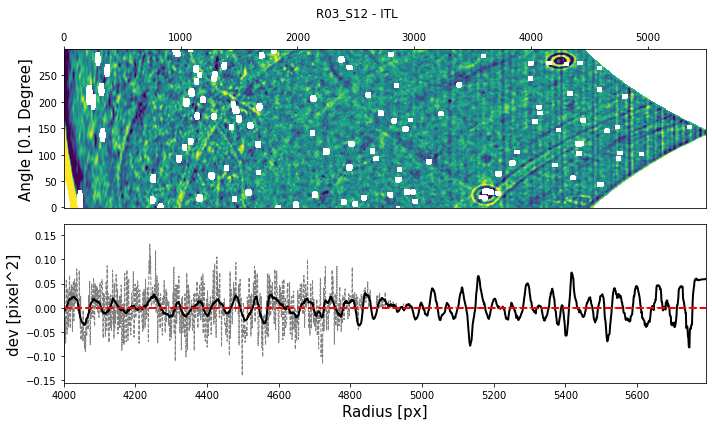

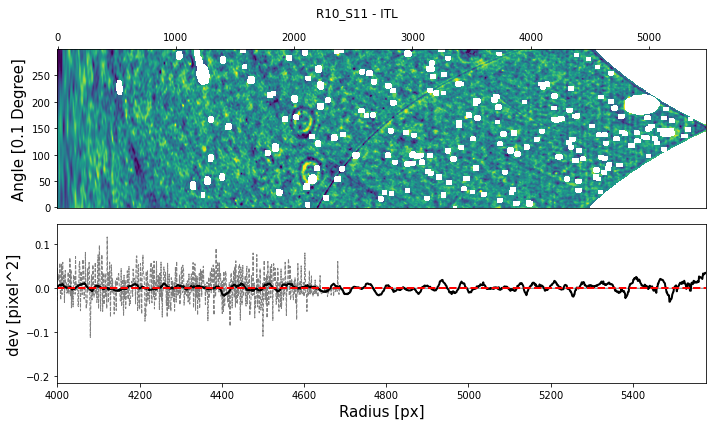

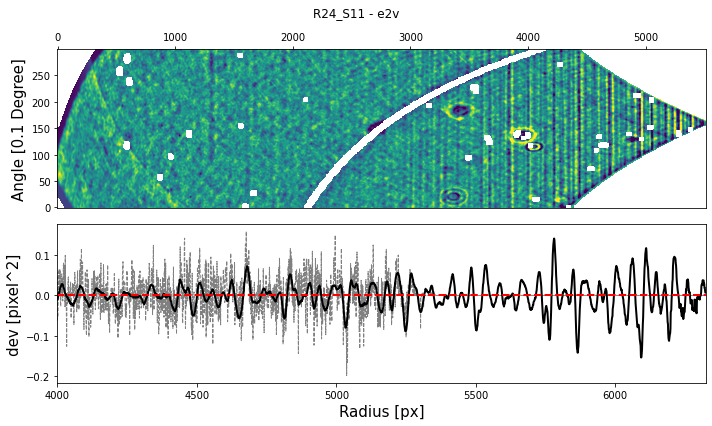

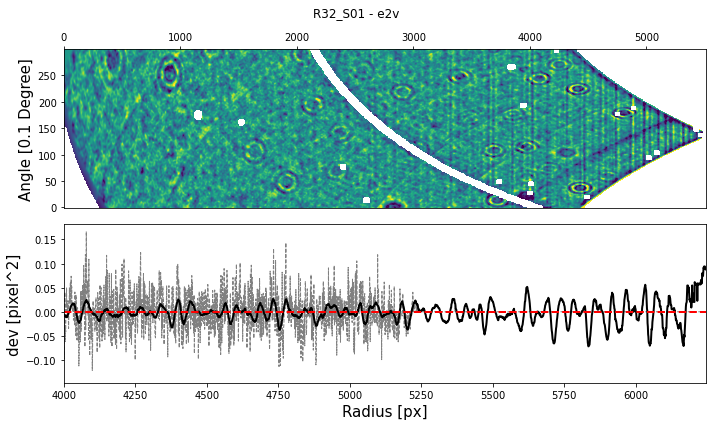

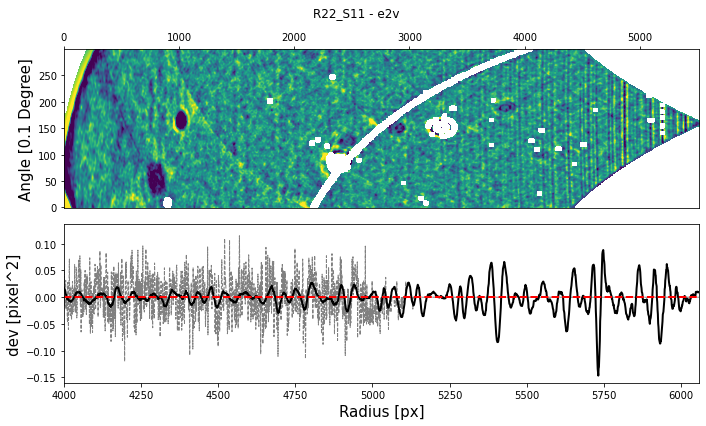

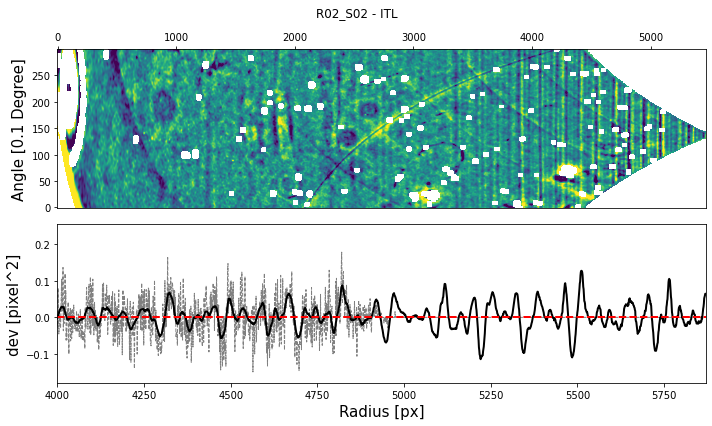

In [12]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('./figures/fig_flatField_treeRingSignal_collection.pdf') as pdf:
    for ring in rings:
        print('Plot %s'%ring.sensorbay)
        ring.title = '%s - %s'%(ring.sensorbay, ring.sensor)
        ring.ylabel = 'dev [pixel^2]'
        #ring.display_images()
        ring.plot_pannel_image_signal()
        plt.xlim(4000,)
        pdf.savefig()
        print('')

Plot R03_S12

Plot R10_S11

Plot R24_S11

Plot R32_S01

Plot R22_S11

Plot R02_S02



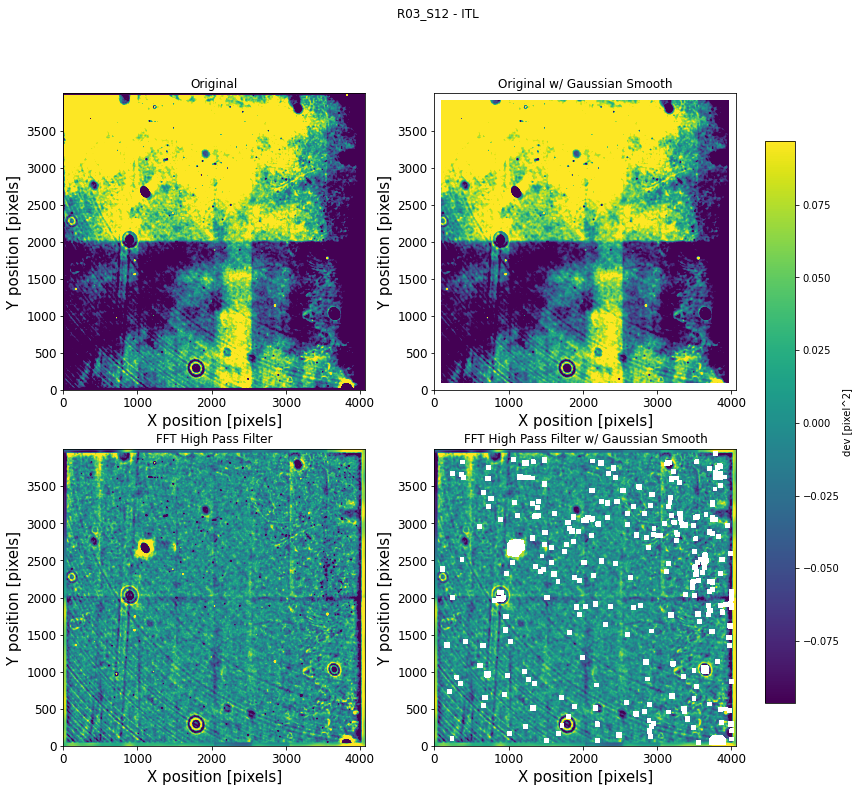

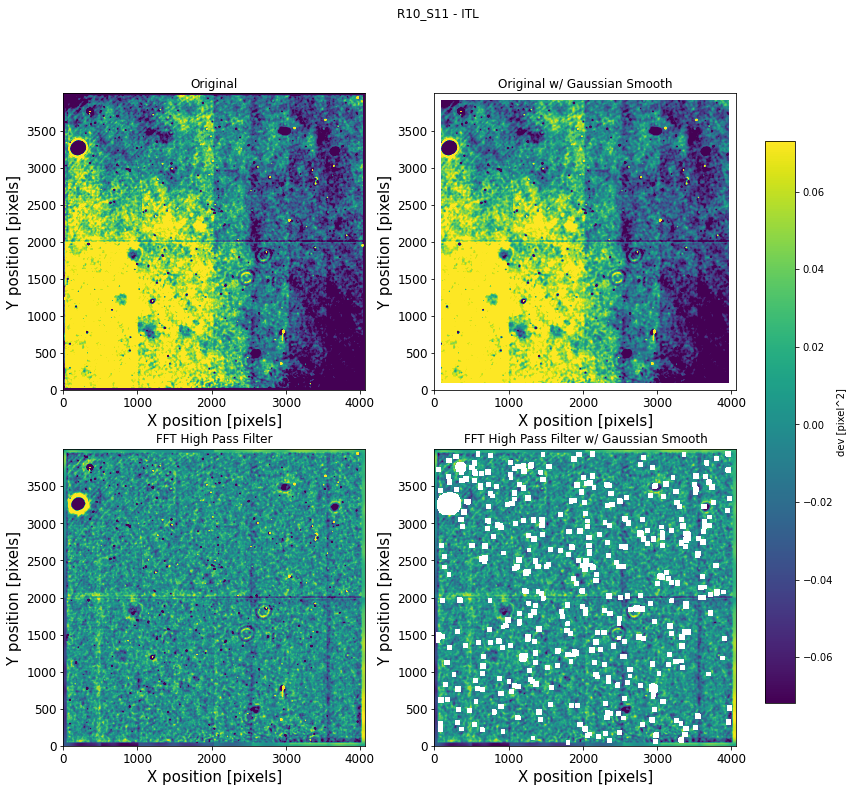

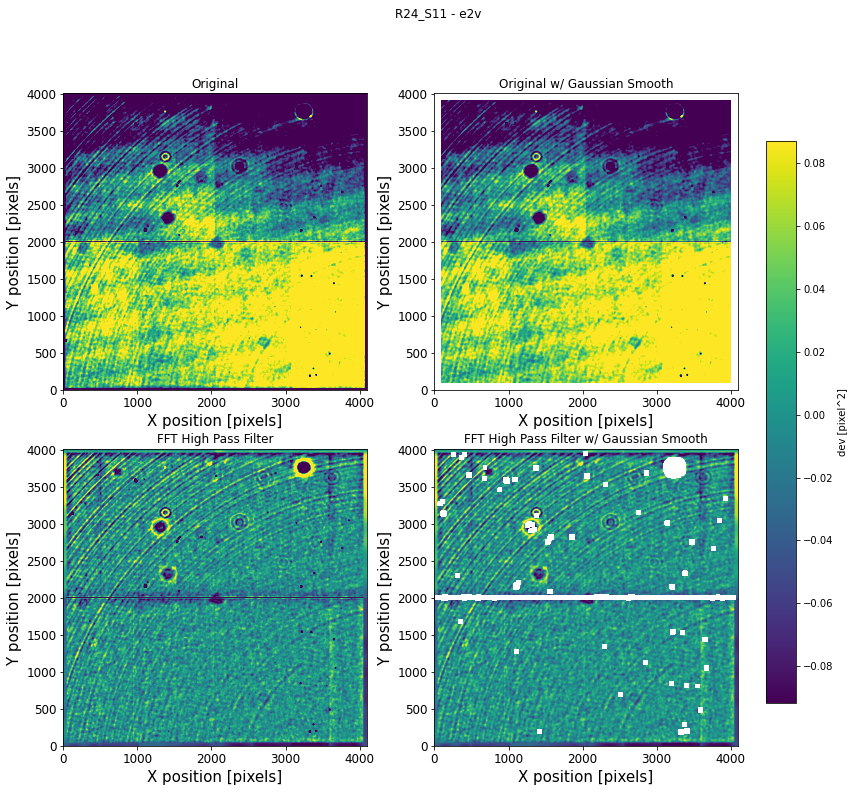

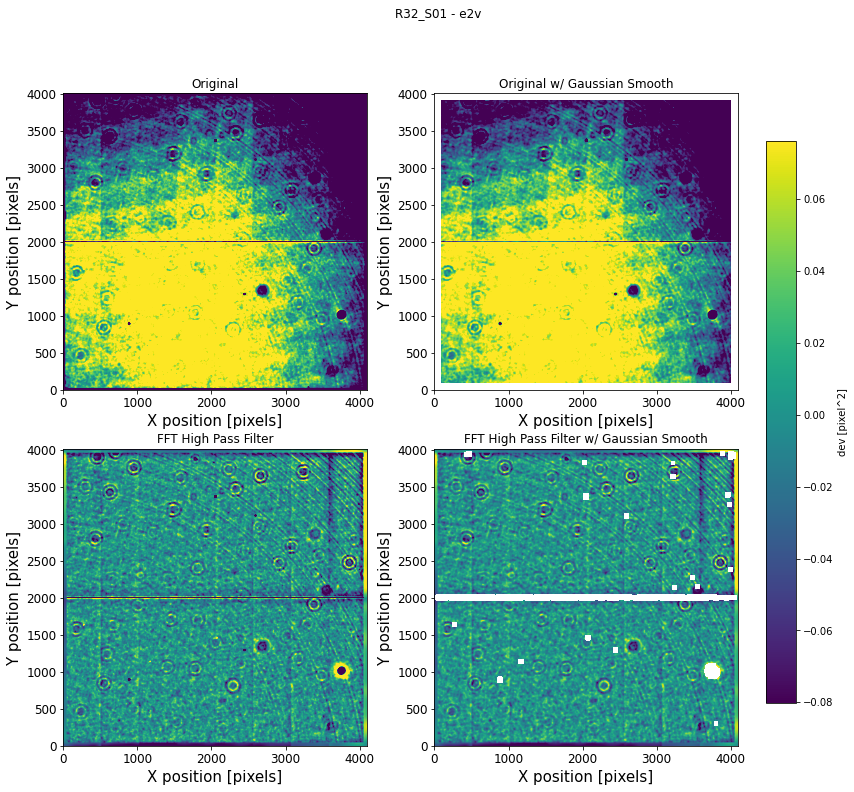

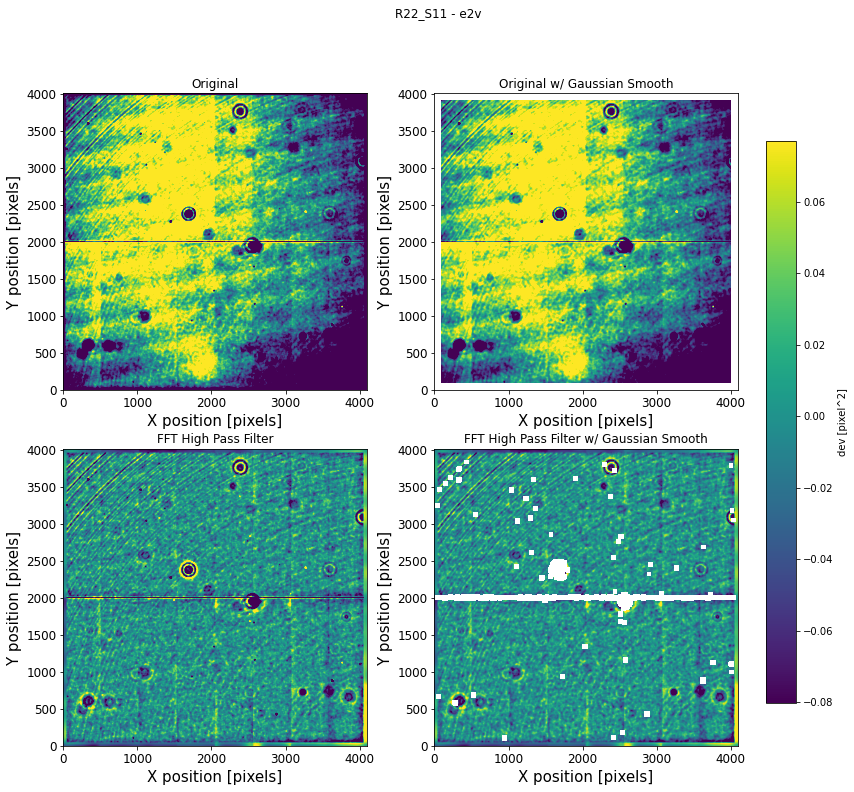

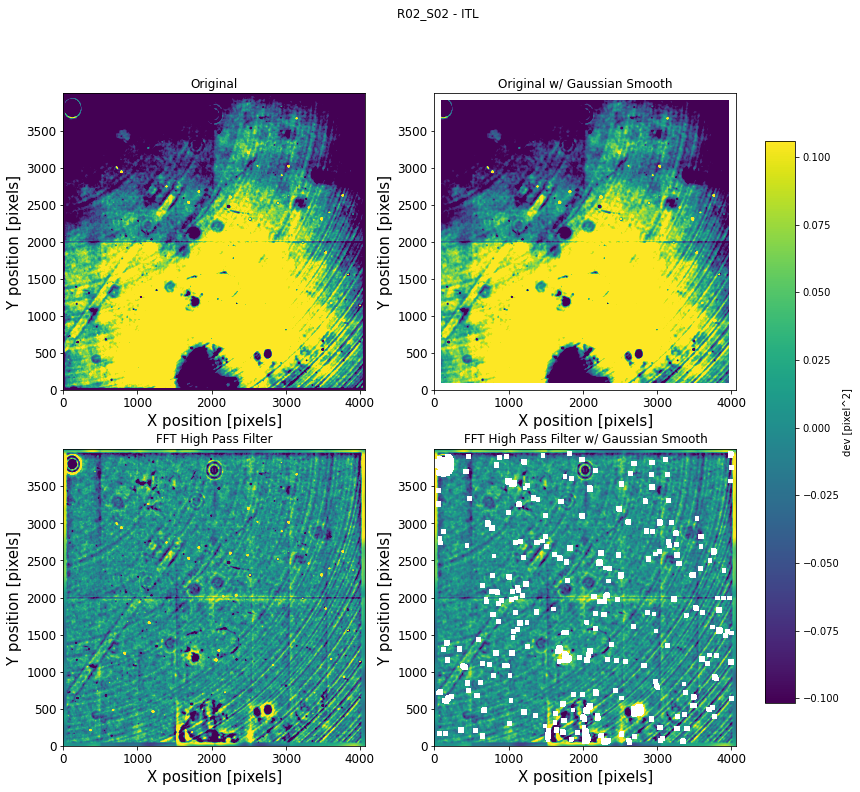

In [13]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('./figures/fig_flatField_image_collection.pdf') as pdf:
    for ring in rings:
        print('Plot %s'%ring.sensorbay)
        ring.title = '%s - %s'%(ring.sensorbay, ring.sensor)
        ring.ylabel = 'dev [pixel^2]'
        ring.display_images()
        pdf.savefig()
        print('')

# Check The Tree Ring Center

In [14]:
ring = rings[1]

print('Sensor bay: %s'%ring.sensorbay)

diff = ring.diff

Sensor bay: R10_S11


In [15]:
from scipy.ndimage.filters import gaussian_filter
from skimage.measure import block_reduce

downscale = 8
# threshold = 0.0003 # For faintest rings
# threshold = 0.0005 # For faint rings
threshold = 0.125 # For stronger rings
# threshold = 0.115 # For strongest rings

diff1 = gaussian_filter(diff.copy(), 8.)
mask = np.abs(diff1) > threshold
diff2 = block_reduce(diff1, (downscale, downscale), func=np.nanmean)
mask2 = block_reduce(mask , (downscale, downscale), func=np.nanmax)
diff2[mask2] = np.nan


In [16]:
# imshow(diff2)

In [17]:
import scipy.optimize as opt
from scipy.stats import binned_statistic_2d, binned_statistic

# Pixel coordinate grid
y2,x2 = np.mgrid[0:diff2.shape[0], 0:diff2.shape[1]]
y,x = np.mgrid[0:diff.shape[0], 0:diff.shape[1]]

def fn_detect(p):
    '''Estimator to locate tree rings center in downscaled images'''
    r = np.hypot(x2-p[0], y2-p[1])
    idx = np.isfinite(diff2) & (diff2 != 0)
    v,bins,_ = binned_statistic(r[idx], diff2[idx], bins=np.arange(np.percentile(r,75), np.percentile(r,90), 1.0))
    return -np.std(v[np.isfinite(v)])

def fn_measure(x0, y0, mask=None, step=4.0, statistic='mean'):
    '''Function to measure tree rings in original image given the center'''
    r = np.hypot(x-x0, y-y0)
    idx = np.isfinite(diff) & (diff != 0)
    if mask is not None:
        idx &= ~mask
    v,bins,_ = binned_statistic(r[idx], diff[idx], bins=np.arange(np.min(r), np.max(r), step), statistic=statistic)
    
    return 0.5*(bins[1:]+bins[:-1]), v

In [18]:
xlow, xhig = 4300., 4600
ylow, yhig = 300, 700.

cc = opt.differential_evolution(fn_detect,[[xlow,xhig],[ylow,yhig]], popsize=40)
print(cc)

x0,y0 = cc.x[0], cc.x[1]
print()
print("Original scale coordinates: %.2f, %.2f"%(x0, y0))

     fun: -0.0032246713853572415
 message: 'Optimization terminated successfully.'
    nfev: 723
     nit: 8
 success: True
       x: array([4595.50536016,  304.53502013])

Original scale coordinates: 4595.51, 304.54


In [19]:
ring.xc, ring.yc = x0,y0
ring.make_polar_transformation(theta_cut= [500, 1000], r_cut=None)
ring.compute_signal()
ring.make_profile(ring.diff2,step=1)

/usr/local/anaconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


(-0.1, 0.1)

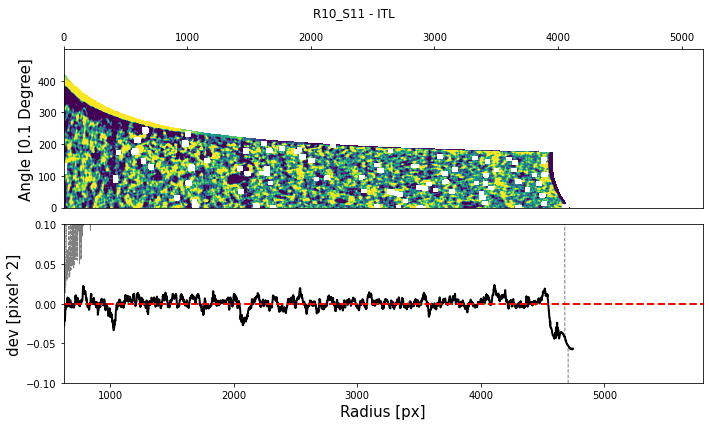

In [20]:
ring.set_levels([-0.025, 0.025])
ring.plot_pannel_image_signal()
plt.ylim(-0.1, 0.1)

In [21]:
ring = rings[-2]

print('Sensor bay: %s'%ring.sensorbay)

diff = ring.diff

Sensor bay: R22_S11


In [22]:
from scipy.ndimage.filters import gaussian_filter
from skimage.measure import block_reduce

downscale = 8
# threshold = 0.0003 # For faintest rings
# threshold = 0.0005 # For faint rings
# threshold = 0.125 # For stronger rings
threshold = 0.105 # For strongest rings

diff1 = gaussian_filter(diff.copy(), 8.)
mask = np.abs(diff1) > threshold
diff2 = block_reduce(diff1, (downscale, downscale), func=np.nanmean)
mask2 = block_reduce(mask , (downscale, downscale), func=np.nanmax)
diff2[mask2] = np.nan


In [23]:
imshow(diff2)

NameError: name 'imshow' is not defined

In [ ]:
import scipy.optimize as opt
from scipy.stats import binned_statistic_2d, binned_statistic

# Pixel coordinate grid
y2,x2 = np.mgrid[0:diff2.shape[0], 0:diff2.shape[1]]
y,x = np.mgrid[0:diff.shape[0], 0:diff.shape[1]]

def fn_detect(p):
    '''Estimator to locate tree rings center in downscaled images'''
    r = np.hypot(x2-p[0], y2-p[1])
    idx = np.isfinite(diff2) & (diff2 != 0)
    v,bins,_ = binned_statistic(r[idx], diff2[idx], bins=np.arange(np.percentile(r,75), np.percentile(r,100), 1.0))
    return -np.std(v[np.isfinite(v)])

def fn_measure(x0, y0, mask=None, step=4.0, statistic='mean'):
    '''Function to measure tree rings in original image given the center'''
    r = np.hypot(x-x0, y-y0)
    idx = np.isfinite(diff) & (diff != 0)
    if mask is not None:
        idx &= ~mask
    v,bins,_ = binned_statistic(r[idx], diff[idx], bins=np.arange(np.min(r), np.max(r), step), statistic=statistic)
    
    return 0.5*(bins[1:]+bins[:-1]), v

In [ ]:
xlow, xhig = 3750., 4100
ylow, yhig = -10., 100.

cc = opt.differential_evolution(fn_detect,[[xlow,xhig],[ylow,yhig]], popsize=100)
print(cc)

x0,y0 = cc.x[0], cc.x[1]
print()
print("Original scale coordinates: %.2f, %.2f"%(x0, y0))

In [ ]:
ring.xc, ring.yc = 3950, y0
ring.make_polar_transformation(theta_cut= [100, 600], r_cut=None)
ring.compute_signal()
ring.make_profile(ring.diff2,step=1)

In [ ]:
ring.set_levels([-0.025, 0.025])
ring.plot_pannel_image_signal()
plt.ylim(-0.1, 0.1)

# Compare with raft 9 Super Flats

In [38]:
def imshow(image, ax=None, qq=[2.5,97.5], show_colorbar=True, **kwargs):
    if ax is None: ax = plt.axes()
    vmin1,vmax1 = np.percentile(image[np.isfinite(image)], qq)
    if 'vmin' not in kwargs.keys():
        kwargs['vmin'] = vmin1
    if 'vmax' not in kwargs.keys():
        kwargs['vmax'] = vmax1
    img = ax.imshow(image, **kwargs)
    if show_colorbar:
        colorbar(img)
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(obj=None, ax=None, size="5%", pad=0.1):
    should_restore = False

    if obj is not None:
        ax = obj.axes
    elif ax is None:
        ax = plt.gca()
        should_restore = True

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=pad)

    plt.colorbar(obj, cax=cax)

    if should_restore:
        plt.sca(ax)

In [17]:
# try a new high pass filter
# 
import numpy
import scipy

def block_view(A, block_shape):
    """Provide a 2D block view of a 2D array.
    
    Returns a view with shape (n, m, a, b) for an input 2D array with
    shape (n*a, m*b) and block_shape of (a, b).
    """
    assert len(A.shape) == 2, '2D input array is required.'
    assert A.shape[0] % block_shape[0] == 0, 'Block shape[0] does not evenly divide array shape[0].'
    assert A.shape[1] % block_shape[1] == 0, 'Block shape[1] does not evenly divide array shape[1].'
    shape = np.array((A.shape[0] / block_shape[0], A.shape[1] / block_shape[1]) + block_shape).astype(int)
    strides = np.array((block_shape[0] * A.strides[0], block_shape[1] * A.strides[1]) + A.strides).astype(int)
    return numpy.lib.stride_tricks.as_strided(A, shape=shape, strides=strides)

def apply_filter(A, smoothing, power=2.0):
    """Apply a hi/lo pass filter to a 2D image.
    
    The value of smoothing specifies the cutoff wavelength in pixels,
    with a value >0 (<0) applying a hi-pass (lo-pass) filter. The
    lo- and hi-pass filters sum to one by construction.  The power
    parameter determines the sharpness of the filter, with higher
    values giving a sharper transition.
    """
    if smoothing == 0:
        return A
    ny, nx = A.shape
    # Round down dimensions to even values for rfft.
    # Any trimmed row or column will be unfiltered in the output.
    nx = 2 * (nx // 2)
    ny = 2 * (ny // 2)
    T = np.fft.rfft2(A[:ny, :nx])
    # Last axis (kx) uses rfft encoding.
    kx = np.fft.rfftfreq(nx)
    ky = np.fft.fftfreq(ny)
    kpow = (kx ** 2 + ky[:, np.newaxis] ** 2) ** (power / 2.)
    k0pow = (1. / smoothing) ** power
    if smoothing > 0:
        F = kpow / (k0pow + kpow) # high pass
    else:
        F = k0pow / (k0pow + kpow) # low pass
    S = A.copy()
    S[:ny, :nx] = np.fft.irfft2(T * F)
    return S

def zero_by_region(data, region_shape, num_sigmas_clip=4.0, smoothing=250, power=4):
    """Subtract the clipped median signal in each amplifier region.
    
    Optionally also remove any smooth variation in the mean signal with
    a high-pass filter controlled by the smoothing and power parameters.
    Returns a an array of median levels in each region and a mask of
    unclipped pixels.
    """
    mask = np.zeros_like(data, dtype=bool)

    # Loop over amplifier regions.
    regions = block_view(data, region_shape)
    masks   = block_view(mask, region_shape)
    ny, nx = regions.shape[:2]
    levels = np.empty((ny, nx))
  
    for y in range(ny):
        for x in range(nx):
            region_data = regions[y, x]
            region_mask = masks[y, x]
            clipped1d, lo, hi = scipy.stats.sigmaclip(
                region_data, num_sigmas_clip, num_sigmas_clip)
            # Add unclipped pixels to the mask.
            region_mask[(region_data > lo) & (region_data < hi)] = True            
            # Subtract the clipped median in place.
            levels[y, x] = np.median(clipped1d)
            region_data -= levels[y, x]
            # Smooth this region's data.
            if smoothing != 0:
                clipped_data = region_data[~region_mask]
                region_data[~region_mask] = 0.
                region_data[:] = apply_filter(region_data, smoothing, power)
                region_data[~region_mask] = clipped_data
                
    return levels, mask
def get_diff_lowpass(image, size=250, power=4.0, use_zero=True, geometry=(2,8)):
    if use_zero:
        image1 = image.copy()
        levels,mask = zero_by_region(image1, (image1.shape[0]/geometry[0], image1.shape[1]/geometry[1]))

        return image1#/image
    else:
        diff = apply_filter(image, size, power=power)
    
        return diff/image

In [19]:
# previous flat fields
sensor = 'ITL'#rings[-1].sensor
fname = 'tmp/%s_flat.fits'%(sensor)
image, hdulist = get_fits(fname)
image = np.flip(image,0)

In [27]:
np.nanmedian(image)

0.9997393

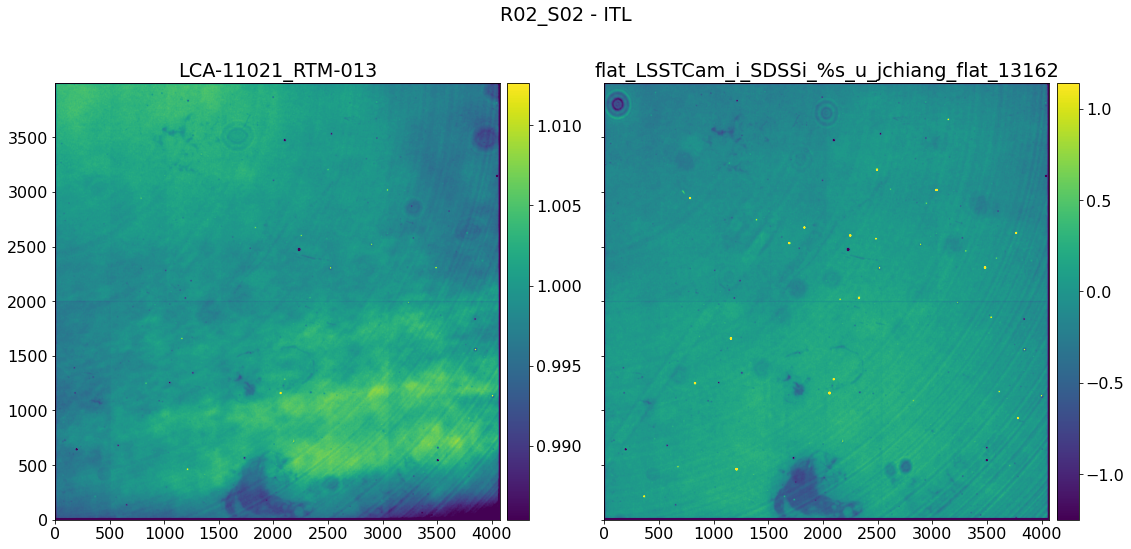

In [28]:
fig, axs = plt.subplots(1,2, figsize=(16,8), sharey='all')
imshow(image, ax=axs[0])
imshow(ring.img, ax=axs[1])

axs[0].set_title('LCA-11021_RTM-013')
axs[1].set_title('flat_LSSTCam_i_SDSSi_%s_u_jchiang_flat_13162')
fig.suptitle('%s - %s'%(ring.sensorbay, ring.sensor))
fig.tight_layout()
fig.savefig('comparing_flatField.png', dpi=75, facecolor='w', transparent=False)

In [29]:
sensor = flatField(slist[1], slist[0])
# sensor.load_image()
sensor.get_center()

ringo = tree_ring_tools(sensor)
ringo.img = image #sensor.image
ringo.img_cut = np.full_like(image, np.nan)
ringo.img_cut[50:-50,50:-50] = image[50:-50,50:-50]
#ring.img_cut = sensor.image

ringo.apply_strech(strech)
# ringo.apply_high_freq_filter(use_zero=False)
ringo.diff = get_diff_lowpass(image, size=250, power=4.0, use_zero=True)
ringo.apply_gaussian_filter(downscale=4)
ringo.apply_mask(threshold=0.5)


ringo.make_polar_transformation()
ringo.compute_signal()
# ringo.make_profile(ring.diff,step=1)
# ringo.save_profile('flatField')

Flat Field: R02_S02, ITL
Welcome to Tree Ring Tools


In [30]:
sensor = flatField(slist[1], slist[0])
sensor.load_image()
sensor.get_center()

ring = tree_ring_tools(sensor)
ring.img = sensor.image
ring.img_cut = np.full_like(sensor.image, np.nan)
ring.img_cut[50:-50,50:-50] = image[50:-50,50:-50]

ring.apply_strech(strech)
# ringo.apply_high_freq_filter(use_zero=True)
ring.diff = get_diff_lowpass(sensor.image, size=250, power=4.0, use_zero=True)
ring.apply_gaussian_filter(downscale=4)
ring.apply_mask(threshold=0.5)


ring.make_polar_transformation()
ring.compute_signal()
ring.make_profile(ring.diff,step=1)
# ringo.save_profile('flatField')

Flat Field: R02_S02, ITL
loaded image
Median: 1.00 [ADU]
Welcome to Tree Ring Tools


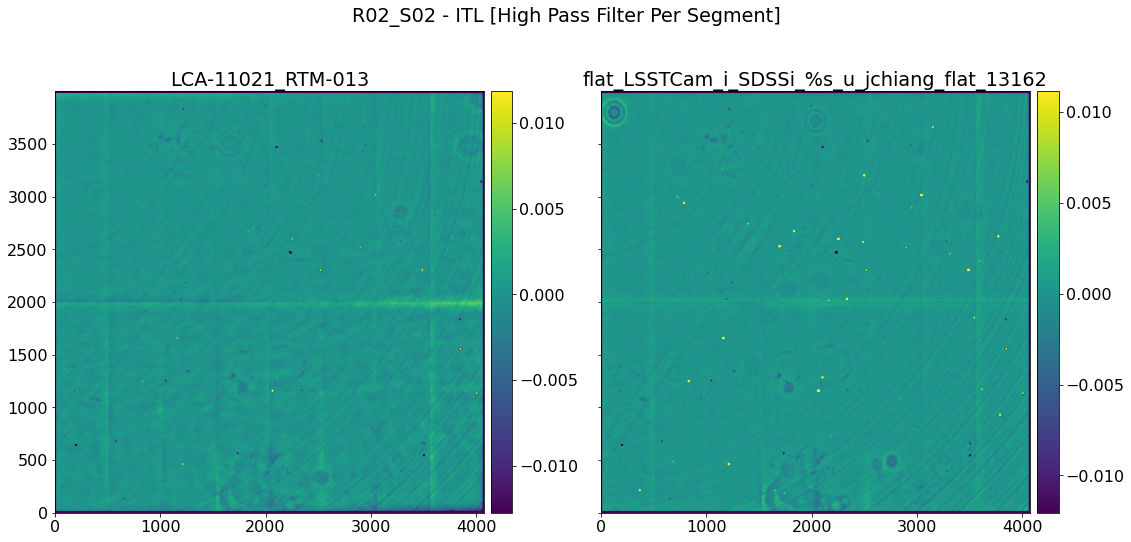

In [31]:
fig, axs = plt.subplots(1,2, figsize=(16,8), sharey='all')
imshow(ringo.diff, ax=axs[0])
imshow(ring.diff, ax=axs[1])

axs[0].set_title('LCA-11021_RTM-013')
axs[1].set_title('flat_LSSTCam_i_SDSSi_%s_u_jchiang_flat_13162')
fig.suptitle('%s - %s [High Pass Filter Per Segment]'%(ring.sensorbay, ring.sensor))
fig.tight_layout()
fig.savefig('comparing_flatField_highPassFilter_perSegment.png', dpi=75, facecolor='w', transparent=False)